In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/solar_roof_segmentation')

In [8]:
# Set your data paths
image_train_folder = "/content/drive/MyDrive/solar_roof_segmentation/AerialImageDataset/train/images" 
label_train_folder = "/content/drive/MyDrive/solar_roof_segmentation/AerialImageDataset/train/labels" 

image_val_folder = "/content/drive/MyDrive/solar_roof_segmentation/AerialImageDataset/train/images_val" 
label_val_folder = "/content/drive/MyDrive/solar_roof_segmentation/AerialImageDataset/train/labels_val" 

image_test_folder = "/content/drive/MyDrive/solar_roof_segmentation/AerialImageDataset/test/images"


In [9]:
# Set desired image size
image_size = (512, 512)

# Read image and label data
image_train_filenames = sorted(os.listdir(image_train_folder))
label_train_filenames = sorted(os.listdir(label_train_folder))

image_val_filenames = sorted(os.listdir(image_val_folder))
label_val_filenames = sorted(os.listdir(label_val_folder))

image_test_filenames = sorted(os.listdir(image_test_folder))

In [11]:
train_images = []
train_labels = []

for image_filename in image_train_filenames:
    image_train_path = os.path.join(image_train_folder, image_filename)
    label_train_filename = image_filename.replace(".tif", ".tif")  # Adjust the label file extension if needed
    label_train_path = os.path.join(label_train_folder, label_train_filename)
    
    # Read and resize the image
    image_train = cv2.imread(image_train_path)
    image_train = cv2.resize(image_train, image_size)
    
    # Normalize the image
    image_train = image_train / 255.0
    
    
    # Read and resize the label
    train_label = cv2.imread(label_train_path, 0)  # Read as grayscale
    train_label = cv2.resize(train_label, image_size)
    
    # Normalize the labels
    train_label = train_label / 255.0
    
    # Append to the data lists
    train_images.append(image_train)
    train_labels.append(train_label)

# Convert data lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print the shapes of the data arrays
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (155, 512, 512, 3)
Train labels shape: (155, 512, 512)


In [12]:
val_images = []
val_labels = []

for image_filename in image_val_filenames:
    image_val_path = os.path.join(image_val_folder, image_filename)
    label_val_filename = image_filename.replace(".tif", ".tif")  # Adjust the label file extension if needed
    label_val_path = os.path.join(label_val_folder, label_val_filename)
    
    # Read and resize the image
    image_val = cv2.imread(image_val_path)
    image_val = cv2.resize(image_val, image_size)
    
    # Normalize the image
    image_val = image_val / 255.0
    
    # Read and resize the label
    val_label = cv2.imread(label_val_path, 0)  # Read as grayscale
    val_label = cv2.resize(val_label, image_size)
    
    # Normalize the label
    val_label = val_label / 255.0
    
    # Append to the data lists
    val_images.append(image_val)
    val_labels.append(val_label)

# Convert data lists to NumPy arrays
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Print the shapes of the data arrays
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Validation images shape: (25, 512, 512, 3)
Validation labels shape: (25, 512, 512)


In [13]:
test_images = []

for image_filename in image_test_filenames:
    image_test_path = os.path.join(image_test_folder, image_filename)
        
    # Read and resize the image
    image_test = cv2.imread(image_test_path)
    image_test = cv2.resize(image_test, image_size)
    
    # Normalize the image
    image_test = image_test / 255.0
    
    # Append to the data list
    test_images.append(image_test)

# Convert data list to a NumPy array
test_images = np.array(test_images)

# Print the shape of the data array
print("Test images shape:", test_images.shape)

Test images shape: (180, 512, 512, 3)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K

def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)
        return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    cross_entropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred)
    total_loss = cross_entropy_loss + dice_loss(y_true, y_pred)

    return tf.reduce_mean(total_loss)

def iou_metric(y_true, y_pred):
    y_pred = tf.math.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou


class UNet:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_vgg19_unet()

    def conv_block(self, input, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(input)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        return x

    def decoder_block(self, input, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
        x = Concatenate()([x, skip_features])
        x = self.conv_block(x, num_filters)
        return x

    def build_vgg19_unet(self):
        """ Input """
        inputs = Input(self.input_shape)

        """ Pre-trained VGG19 Model """
        vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

        """ Encoder """
        s1 = vgg19.get_layer("block1_conv2").output       ## (512 x 512)
        s2 = vgg19.get_layer("block2_conv2").output       ## (256 x 256)
        s3 = vgg19.get_layer("block3_conv4").output       ## (128 x 128)
        s4 = vgg19.get_layer("block4_conv4").output       ## (64 x 64)

        """ Bridge """
        b1 = vgg19.get_layer("block5_conv4").output       ## (32 x 32)

        """ Decoder """
        d1 = self.decoder_block(b1, s4, 512)              ## (64 x 64)
        d2 = self.decoder_block(d1, s3, 256)              ## (128 x 128)
        d3 = self.decoder_block(d2, s2, 128)              ## (256 x 256)
        d4 = self.decoder_block(d3, s1, 64)               ## (512 x 512)

        """ Output """
        outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

        model = Model(inputs, outputs, name="VGG19_U-Net")
        return model

    def compile(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    def train(self, x, y, epochs=1, batch_size=32, validation_data=None):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=['accuracy', iou_metric])
        lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001, verbose=1)
        history=self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=validation_data, callbacks=[lr_reducer])
        return history

    def predict(self, x):
        return self.model.predict(x)

In [21]:
input_shape = (512, 512, 3)
unet = UNet(input_shape)

# Compile the model
unet.compile(optimizer='adam')

# Print the model summary
unet.model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [24]:
# Train the model
epochs = 4
batch_size = 16
validation_data = (val_images, val_labels)  # Assuming you have validation data
history_final1 = unet.train(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_labels))

Epoch 1/4
10/10 [==============================] - 17s 487ms/step - loss: 1.3603 - accuracy: 0.9166 - iou_metric: 0.6108 - val_loss: 1.4080 - val_accuracy: 0.9212 - val_iou_metric: 0.5419 - lr: 0.0010
Epoch 2/4
10/10 [==============================] - 4s 421ms/step - loss: 1.3569 - accuracy: 0.9223 - iou_metric: 0.6282 - val_loss: 1.4112 - val_accuracy: 0.9192 - val_iou_metric: 0.5114 - lr: 0.0010
Epoch 3/4
10/10 [==============================] - 4s 422ms/step - loss: 1.3544 - accuracy: 0.9246 - iou_metric: 0.6416 - val_loss: 1.4266 - val_accuracy: 0.9049 - val_iou_metric: 0.3901 - lr: 0.0010
Epoch 4/4
10/10 [==============================] - 4s 422ms/step - loss: 1.3543 - accuracy: 0.9259 - iou_metric: 0.6423 - val_loss: 1.4120 - val_accuracy: 0.9187 - val_iou_metric: 0.5041 - lr: 0.0010


In [25]:
history_final1

In [26]:
history_final1.history['iou_metric'][:9]

[0.6108371615409851,
 0.6281588673591614,
 0.6415937542915344,
 0.6423327922821045]

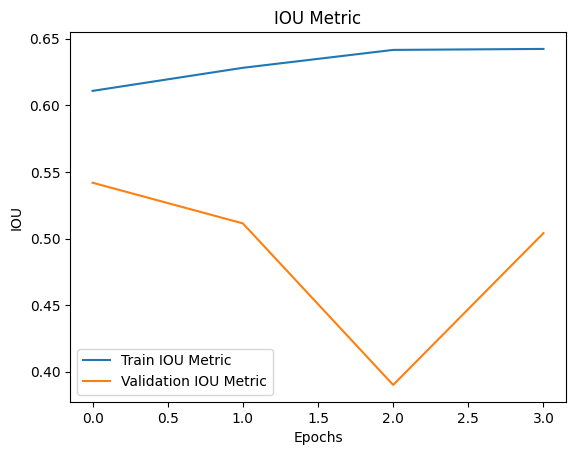

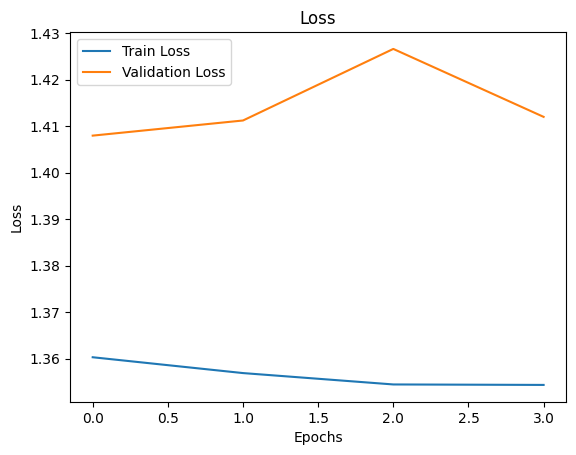

In [29]:
import matplotlib.pyplot as plt


# Get the IOU metric values from the history
iou_metric = history_final1.history['iou_metric'][:9]
val_iou_metric = history_final1.history['val_iou_metric'][:9]

# Get the loss values from the history
loss = history_final1.history['loss'][:9]
val_loss = history_final1.history['val_loss'][:9]

# Plot the IOU metric vs validation IOU metric
plt.plot(iou_metric, label='Train IOU Metric')
plt.plot(val_iou_metric, label='Validation IOU Metric')
plt.title('IOU Metric')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig("/content/drive/MyDrive/solar_roof_segmentation/metric1.png")
plt.show()

# Plot the loss vs validation loss
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/solar_roof_segmentation/loss1.png")
plt.show()

In [28]:
import pickle

# Assuming you have the model's history variable named "history"
# Save the history variable to a pickle file
pickle_file = "/content/drive/MyDrive/solar_roof_segmentation/model_final1.pickle"
with open(pickle_file, 'wb') as f:
    pickle.dump(history_final1.history, f)

In [33]:
unet.model.save("/content/drive/MyDrive/solar_roof_segmentation/model_final_1.h5")

In [30]:
test_labels_pred = unet.predict(test_images)


6/6 [==============================] - 29s 2s/step


array([[[[1.47509258e-04],
         [2.59591125e-05],
         [7.35944268e-05],
         ...,
         [2.57286680e-04],
         [1.89075407e-04],
         [4.92399384e-04]],

        [[1.04464663e-04],
         [2.26888528e-06],
         [1.36419831e-05],
         ...,
         [2.81876401e-05],
         [9.14743487e-06],
         [1.63068500e-04]],

        [[1.01653779e-04],
         [1.36789856e-06],
         [1.07907199e-05],
         ...,
         [2.20917664e-05],
         [1.47930277e-05],
         [2.66738934e-04]],

        ...,

        [[1.67489925e-04],
         [1.81879848e-04],
         [2.98524596e-04],
         ...,
         [2.27615601e-04],
         [2.10078491e-04],
         [5.59426961e-04]],

        [[1.49495332e-04],
         [6.48572386e-05],
         [1.62607044e-04],
         ...,
         [5.39242137e-05],
         [1.08150671e-04],
         [1.65321253e-04]],

        [[2.28973178e-04],
         [1.67756531e-04],
         [2.48030905e-04],
         ...,
 

(155, 512, 512, 3)


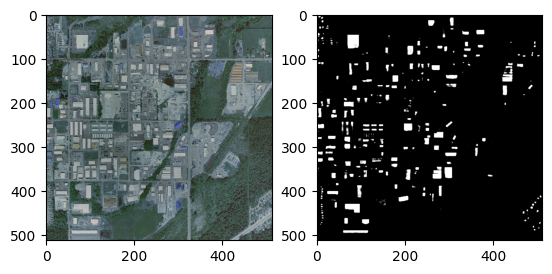

In [31]:
print(train_images.shape)
plt.subplot(1,2,1)
plt.imshow(test_images[21], cmap="gray");
plt.subplot(1,2,2)
plt.imshow(test_labels_pred[21], cmap="gray");

In [ ]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#train_datagen = ImageDataGenerator(rescale=1./255)
#target_size = (224, 224)

#train_generator = train_datagen.flow_from_directory(
    #'data/train/',
    #target_size=target_size,
    #batch_size=32)

#model.fit(train_generator,
          #epochs=num_epochs)